# Package import

In [1]:
from glob import glob
from path import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import snebeat.behav_tools as bat

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Plot formatting

In [2]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

def sig_star(p, x=1, y=1):
    sig_label = ['n.s.', '*', '**', '***', '****'][(p < [0.05, 0.01, 0.001, 0.0001]).sum()]
    if sig_label == 'n.s.':
        fontsize = 17
    else:
        fontsize = 20
    plt.text(x, y, sig_label, fontsize=fontsize)

# Main

In [3]:
behavs = ['push', 'resist', 'retreat']

## Join files from videos

### Post-ablation

In [8]:
path = Path('/Users/borakn/Documents/temp')

for animal in ['890A', '890B', '890C', '890D', '362A', '362B', '362C', '362D', 'No focal subject']:
    part1 = path/f'post-ablation_part1_{animal}.csv'
    part2 = path/f'post-ablation_part2_{animal}.csv'
    files = [part1, part2]
    TT_binary = pd.read_csv(path/'post-ablation_No focal subject.csv')
    
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        dfs.append(df)
        
    dfs = pd.concat(dfs)
    dfs.reset_index(drop=True)
    dfs['tube test'] = TT_binary['tube test'].astype(int)
    dfs.to_csv(path/f'post-ablation_{animal}.csv', index=False)
    

### Other conditions

In [31]:
path = Path('/Users/borakn/Documents/temp')
condition = 'post-NMDA'

for animal in ['982A', '982B', '982C', '982D', 'No focal subject']:
    file = path/f'{condition}_{animal}.csv'
    TT_binary = pd.read_csv(path/f'{condition}_No focal subject.csv')
    
    dfs = []
    df = pd.read_csv(file)
    dfs.append(df)
        
    dfs = pd.concat(dfs)
    dfs.reset_index(drop=True)
    dfs['tube test'] = TT_binary['tube test'].astype(int)
    dfs.to_csv(path/f'{condition}_{animal}.csv', index=False)
    

## Quantify behaviour

In [31]:
glob(path/'*')

[]

In [34]:
path = Path('../Data/pre:post ablation behavior')

conditions = ['pre-ablation', 'post-ablation', 'pre-NMDA', 'post-NMDA']

results = []
for condition in conditions:
    print(condition)
    
    files = glob(path/f'{condition}_[0-9]*.csv')
    for file in files:
        
        try:
            df = pd.read_csv(file)
            animal = Path(file).name.split('_')[-1].split('.')[0]
        except FileNotFoundError:
            print('error')
            continue

        segments, bounds = bat.segment(df, state_ref='tube test')
        segments, bounds = bat.only_annotated(segments, bounds)

        for trial, segment in enumerate(segments):
            duration, _, _, _ = bat.behaviour_metrics(segment[behavs], window=None, fr=1)

            row = [animal, trial, condition, *[duration[behav] for behav in behavs], segment.shape[0] / 30]
            results.append(row)
        
results = pd.DataFrame(np.stack(results), 
                       columns=['animal', 'trial', 'condition', *behavs, 'tt_length'])

'''results.push = results.push.astype(float)
results.resist = results.resist.astype(float)
results.retreat = results.retreat.astype(float)
results['tt_length'] = results['tt_length'].astype(float)'''

results[['trial', 'push', 'resist', 'retreat', 'tt_length']]= results[['trial', 'push', 'resist', 'retreat', 'tt_length']].map(pd.to_numeric, errors='coerce')
results = results.groupby(['animal', 'condition']).mean().reset_index()

results.condition = pd.Categorical(results.condition, categories=conditions, ordered=True)
results = results.sort_values(by='condition')

pre-ablation
post-ablation
pre-NMDA
post-NMDA


## Visualisation

push
                   experiment                    t                      p
0  pre-ablation post-ablation  -4.3839859402263075  0.0032188325166591565
1          pre-NMDA post-NMDA   1.4738519009042526    0.23695494722535854
resist
                   experiment                   t                     p
0  pre-ablation post-ablation  -3.748024955828504  0.007186733764943243
1          pre-NMDA post-NMDA  -5.654297786450172  0.010951475305172109
retreat
                   experiment                    t                    p
0  pre-ablation post-ablation   -2.303696854140047  0.05469235296350277
1          pre-NMDA post-NMDA  -2.2750057403332287   0.1074282289317948


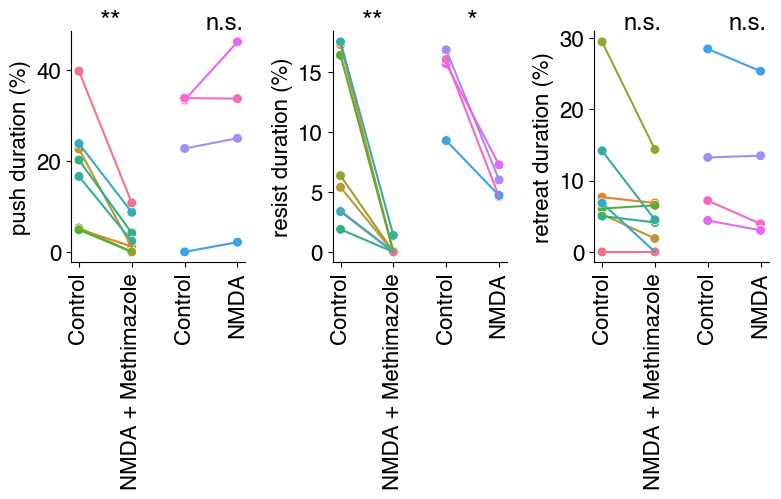

In [36]:
plt.figure(figsize=[3*len(behavs),3])

experiments = np.array(conditions).reshape(-1,2)

for n, behav in enumerate(behavs):

    plt.subplot(1, len(behavs), n+1)
    plt.subplots_adjust(wspace=0.5)
    
    sns.scatterplot(results, x='condition', y=behav, hue='animal', s=[50])
    sns.lineplot(results, x='condition', y=behav, hue='animal')
    
    plt.legend([], frameon=False)
    plt.xlabel('')
    plt.ylabel(f'{behav} duration (%)')
    
    #plt.xlim(-0.3, 1.3)
    plt.xticks([0,1,2,3], ['Control', 'NMDA + Methimazole', 'Control', 'NMDA'], rotation=90)
    
    stats = []
    for m, experiment in enumerate(experiments):
        subset = results[np.isin(results.condition, experiment)].copy()
        subset.condition = pd.Categorical(subset.condition, categories=experiment, ordered=True)
        
        model = smf.ols(f'{behav} ~ condition + animal', subset).fit()
        t = model.tvalues[f'condition[T.{experiment[1]}]']
        p = model.pvalues[f'condition[T.{experiment[1]}]']

        stats.append([' '.join(experiment), t, p])
    
        sig_star(p, 0.4 + m*2, results[behav].max()*1.06)

    print(behav)
    stats = pd.DataFrame(np.stack(stats), columns=['experiment', 't', 'p'])
    print(stats)
    
plt.savefig('../Plots/Generalization/Ablation-dependent behaviour changes.png', dpi=300, bbox_inches='tight')